# Overview


This notebook describes the different stages to build up different deep learning models trained over the dataset called **FakeNewsNet** by using pretrained **Word2Vec** and **Glove** Embeddings, for the automatic fake news detection

List of Deep Learning algorithms included 
- 1D CNN
- LSTM
- BiLSTM



## 1. Loading Python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re
import pickle
from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate,BatchNormalization,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.backend import clear_session



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-07-04 09:55:28.072575: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-04 09:55:28.077669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-04 09:55:28.077686: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

#### Loading the Full prepared dataset - FakeNewsNet cleaned data using nltk library on earlier works

In [ ]:
#creating a data frame
df = pd.read_csv("Updated//Fakenewsnet_Cleanedfulltext1.csv")

***
## 2. Dataset Cleaning and Preprocessing


#### Remove null values in the fulltext column

In [3]:
df = df[df['fulltext'].notna()]

#### Shuffling the rows

In [6]:
df = df.sample(frac=1).reset_index(drop=True)

#### Clean data using the built in cleaner function from  gensim library

In [7]:
df['cleantext'] = df['fulltext'].apply(lambda x: gensim.utils.simple_preprocess(x))

***

## 3. Model Training and Evaluation

### Splitting dataset into Features and Class labels

In [8]:
X=df['cleantext']
y=df['class']

#### Train and Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

since we need to pad  the sentences before feed to the model, For this, we need to find the maximum lenght of any document.

In [10]:
maxi=-1
for i,sent in enumerate(df['cleantext']):
    if(len(sent)>maxi):
        maxi=len(sent)
print(maxi)

17351


In [11]:
print("Maximum Length of the sequence : ",maxi)

Maximum Length of the sequence :  17351


#### Now we intialise Keras Tokeniser and fit on training set

In [12]:
tokenzr = Tokenizer()

In [13]:
tokenzr.fit_on_texts(X)
vocab_size = len(tokenzr.word_index) + 1

#### Encode  texts to sequence format for both training set and test set 

In [14]:
encd_train = tokenzr.texts_to_sequences(X_train)
encd_test = tokenzr.texts_to_sequences(X_test)

##### Hyperparameter Configuration Setting for the model training

In [15]:
maxi=5000  # max lenght of a text
vocab_size = len(tokenzr.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor

**Pad both training and test encoded data to maximum length variable value**

In [16]:
pad_train= pad_sequences(encd_train, maxlen=maxi, padding='post')
pad_train.shape   

(16289, 5000)

In [17]:
pad_test= pad_sequences(encd_test, maxlen=maxi, padding='post')
pad_test.shape

(4073, 5000)

## Feature Extractions using pretrained Word2Vec model

##### Load the  pretrained model

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

#### After downloading it, you can load it as follows

In [18]:
path_to_model = 'Embeddings//GoogleNews-vectors-negative300.bin'

In [19]:
from gensim.models.keyedvectors import KeyedVectors
%time w2v_model_pretrained = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
print('done loading Word2Vec')

CPU times: user 17.9 s, sys: 1.39 s, total: 19.3 s
Wall time: 19.4 s
done loading Word2Vec


#### Then inspect the model by getting the list of index of key values from the pretrained model

In [21]:
# total numberof extracted words.
word2vec_vocab=w2v_model_pretrained.index_to_key
print("The total number of words are : ",len(word2vec_vocab))

The total number of words are :  3000000


In [22]:
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]

#### Finding out the number of key value pairs of  vocabulary count and save those in a dictionary

In [23]:
word_vec_dict_pre={}
for word in word2vec_vocab:
    word_vec_dict_pre[word]=w2v_model_pretrained.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict_pre)) # should come equal to vocab size

The no of key-value pairs :  3000000


#### Creation of Embedding matrix which is a list of all words and their corresponding embeddings

In [24]:
embedded_matrix_2=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tokenzr.word_index.items():
    embedded_vec=word_vec_dict_pre.get(word)
    if embedded_vec is not None:  # word is in the vocabulary learned by the w2v model
        embedded_matrix_2[i]=embedded_vec

####  User defined helper functions to plot training and testing accuracy of the trained model

This function is using to save the loss and accuracy metrics of the training and test sets from the given input parameter which is a keras history callback object obtained during the model traning

In [25]:
import matplotlib.pyplot as plt

    
def plot_loss_and_acc_from_hist2(hist_df):
    print('Training Accuracy :',hist_df.iloc[-1]['accuracy'])
    print('Validation Accuracy :',hist_df.iloc[-1]['val_accuracy'])
    print('Precision :',hist_df.iloc[-1]["precision"])
    print('Recall :',hist_df.iloc[-1]["recall"])
    print('F1 Score :',hist_df.iloc[-1]["f1score"])
    train_loss = hist_df["loss"]
    train_acc = hist_df["accuracy"]
    val_loss = hist_df["val_loss"]
    val_acc = hist_df["val_accuracy"]
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");    

    


#### User defined helper functions to create the confusion matrix and normalised confusion matrix 

The below scripts is using to create the confusion matrix and normalised confusion matrix based on the predictions and actual truth lables

In [26]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

***
## Model Training

### Using 1D CNN

#### Checkpoint and EarlyStopping configuration setting for the model training

In [ ]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_CNN_WORD2VEC_PRETRAINED_V3.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model 

In [ ]:
warnings.filterwarnings('ignore')
cnn_model=Sequential()
cnn_model.add(Embedding(vocab_size,embed_dim,input_length=maxi))
cnn_model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1, activation='sigmoid'))
# compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(cnn_model.summary())

#### Model Training 

In [ ]:
history_cnn_word2vec=cnn_model.fit(pad_train,y_train,epochs=4,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

#### Load the trained model

In [28]:
from tensorflow.keras.models import load_model
cnn_model = load_model('outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_CNN_WORD2VEC_PRETRAINED_V3.h5')

2022-07-04 09:57:32.343574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-04 09:57:32.343736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-04 09:57:32.343843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

#### Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [44]:
y_pred=cnn_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

128/128 [==============================] - 8s 62ms/step


In [45]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.8384483181929782
precision = 0.7340425531914894
recall = 0.5465346534653466
f1score = 0.626560726447219
[[2863  200]
 [ 458  552]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      3063
           1       0.73      0.55      0.63      1010

    accuracy                           0.84      4073
   macro avg       0.80      0.74      0.76      4073
weighted avg       0.83      0.84      0.83      4073



**Save the classification report to csv**

In [46]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_CNN_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.862090,0.934705,0.896930,3063.000000
1,0.734043,0.546535,0.626561,1010.000000
accuracy,0.838448,0.838448,0.838448,0.838448
macro avg,0.798066,0.740620,0.761745,4073.000000
weighted avg,0.830337,0.838448,0.829885,4073.000000


**Plot confusion matrix using the user defined functions created earlier**

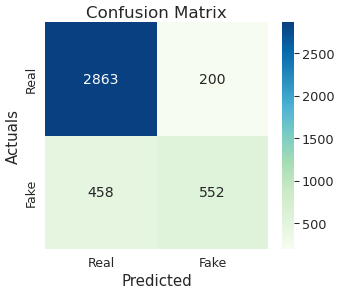

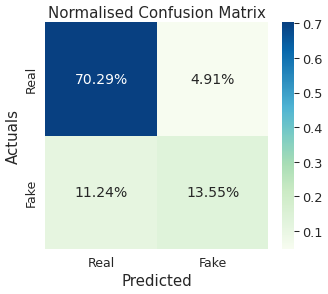

In [48]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakenewsnet_dl_word2vec//fakenewsnet_cnn_w2v_cmtrx.png"
path2="outputs//fakenewsnet_dl_word2vec//fakenewsnet_cnn_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.8789041638374329
Validation Accuracy : 0.8431553244590759
Precision : 0.7093153759820426
Recall : 0.6257425742574257
F1 Score : 0.6649132035770647


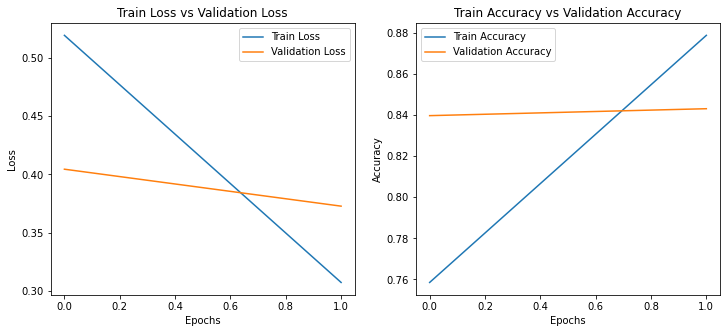

In [27]:
hist_df = pd.read_csv("outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_CNN_WORD2VEC_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("CNN Completed")

***

### Using LSTM

#### Checkpoint and EarlyStopping configuration setting for the model training

In [59]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_LSTM_WORD2VEC_PRETRAINED_V3.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model 

In [61]:
from keras.initializers import Constant
lstm_model=Sequential()
lstm_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedded_matrix_2),trainable=True))
lstm_model.add(LSTM(128,return_sequences=True,dropout=0.2)) # loss stucks at about 
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dense(64,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [62]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10000, 300)        29623500  
                                                                 
 lstm_1 (LSTM)               (None, 10000, 128)        219648    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29,851,469
Trainable params: 29,851,469
Non-trainable params: 0
__________________________________________

#### Model Training

In [63]:
history_lstm_word2vec=lstm_model.fit(pad_train,y_train,epochs=3,batch_size=200,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
66/66 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.7583 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2ab104adb488> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.8619446158409119
Validation Accuracy : 0.8486801981925964
Precision : 0.8216463414634146
Recall : 0.5336633663366337
F1 Score : 0.6470588235294117


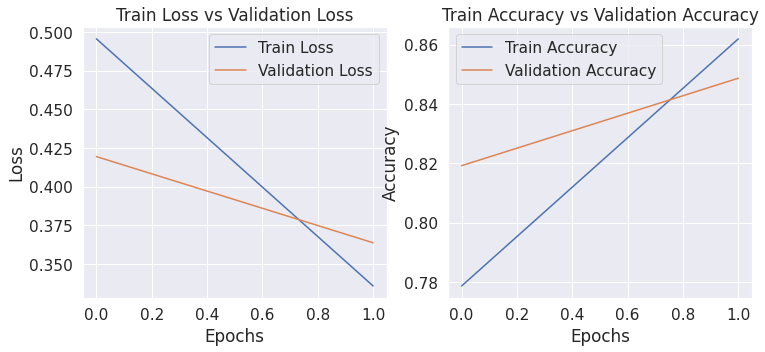

In [49]:
hist_df = pd.read_csv("outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_LSTM_WORD2VEC_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("LSTM Completed")

#### Load the trained model

In [50]:
from tensorflow.keras.models import load_model
lstm_model = load_model('outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_LSTM_WORD2VEC_PRETRAINED_V3.h5')

#### Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [51]:
y_pred=lstm_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
128/128 [==============================] - 265s 2s/step


In [55]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

**Save the classification report to csv**

In [ ]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_LSTM_WORD2VEC_clasifctnrpt.csv")
df.head()

**Plot confusion matrix using the user defined functions created earlier**

In [ ]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakenewsnet_dl_word2vec//fakenewsnet_lstm_w2v_cmtrx.png"
path2="outputs//fakenewsnet_dl_word2vec//fakenewsnet_lstm_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

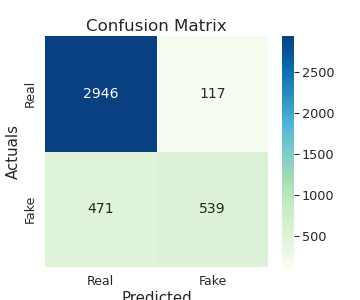

In [59]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_word2vec//fakenewsnet_lstm_w2v_cmtrx.png")

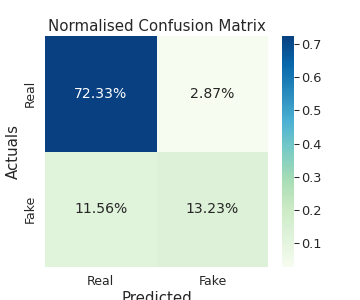

In [58]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_word2vec//fakenewsnet_lstm_w2v_ncmtrx.png")

***

### Using BiLSTM

#### Checkpoint and EarlyStopping configuration setting for the model training

In [30]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_BILSTM_WORD2VEC_PRETRAINED_V3.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model 

In [31]:
from keras.initializers import Constant
bilstm_model=Sequential()
bilstm_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedded_matrix_2),trainable=True))
bilstm_model.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))) # loss stucks at about 
bilstm_model.add(GlobalMaxPooling1D())
bilstm_model.add(Dense(64,activation='relu'))
bilstm_model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
bilstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
bilstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 300)        29293800  
                                                                 
 bidirectional (Bidirectiona  (None, 10000, 256)       439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29,749,609
Trainable params: 29,749,609


#### Model Training

In [33]:
history_bilstm_word2vec=bilstm_model.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.7858 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b7643825ea0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

#### Load the saved model

In [ ]:
from tensorflow.keras.models import load_model
bilstm_model = load_model('outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_BILSTM_WORD2VEC_PRETRAINED_V3.h5')

#### Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [ ]:
y_pred=bilstm_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

In [ ]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

**Save the classification report to csv**

In [ ]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_BILSTM_WORD2VEC_clasifctnrpt.csv")
df.head()

**Plot confusion matrix using the user defined functions created earlier**

In [ ]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakenewsnet_dl_word2vec//fakenewsnet_lstm_w2v_cmtrx.png"
path2="outputs//fakenewsnet_dl_word2vec//fakenewsnet_lstm_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

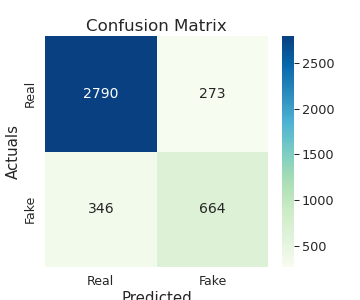

In [62]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_word2vec//fakenewsnet_bilstm_w2v_cmtrx.png")

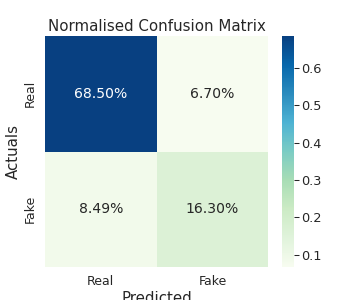

In [63]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_word2vec//fakenewsnet_bilstm_w2v_ncmtrx.png")

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.9194996356964112
Validation Accuracy : 0.8483732342720032
Precision : 0.7086446104589115
Recall : 0.6574257425742575
F1 Score : 0.6820749871597329


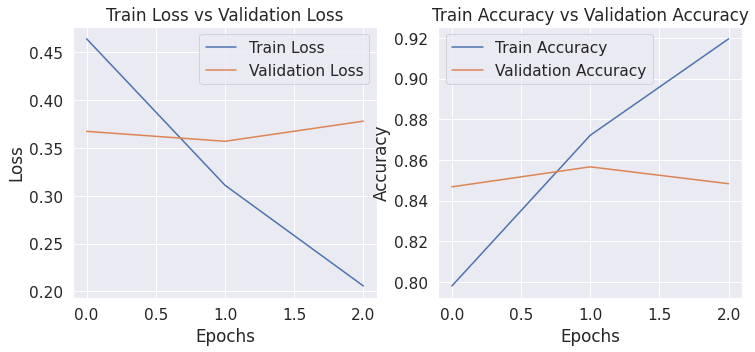

In [60]:
hist_df = pd.read_csv("outputs//fakenewsnet_dl_word2vec//model_FAKENEWSNET_BILSTM_WORD2VEC_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("LSTM Completed")

***

## Feature Extraction Pretrained Glove

##### Download the pretrained zip file

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

#### Load the downloaded the 300 dimension Glove pretrained model "glove.6B.300d.txt" in a path and convert to word2vec format",

In [19]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [20]:
glove_path = 'Embeddings//glove.6B.300d.txt'

In [21]:
import os
glove_embeddings_index = {}
f = open(os.path.join(glove_path), encoding="utf8")

#### Finding out the number of key value pairs of  vocabulary count and save those in a dictionary

In [22]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings_index[word] = coefs
f.close()

In [23]:
print('Total %s word vectors in Glove.' % len(glove_embeddings_index))


Total 400000 word vectors in Glove.


#### Creation of Embedding matrix which is a list of all words and their corresponding embeddings

In [24]:
embedding_gmatrix = np.random.random((len(tokenzr.word_index) + 1, embed_dim))
for word, i in tokenzr.word_index.items():
    embedding_gvector = glove_embeddings_index.get(word)
    if embedding_gvector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_gmatrix[i] = embedding_gvector

*** 
### Model Training

### 1D CNN

#### Checkpoint and EarlyStopping configuration setting for the model training

In [53]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_CNN_GLOVE_V1.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model

In [54]:
warnings.filterwarnings('ignore')
cnn_model_g=Sequential()
cnn_model_g.add(Embedding(vocab_size,embed_dim,input_length=maxi))
cnn_model_g.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
cnn_model_g.add(Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu'))
cnn_model_g.add(MaxPooling1D())
cnn_model_g.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model_g.add(MaxPooling1D())
cnn_model_g.add(Flatten())
cnn_model_g.add(Dense(128, activation='relu'))
cnn_model_g.add(Dropout(0.4))
cnn_model_g.add(Dense(64, activation='relu'))
cnn_model_g.add(Dropout(0.2))
cnn_model_g.add(Dense(1, activation='sigmoid'))
# compile the model
cnn_model_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(cnn_model_g.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 300)        29595000  
                                                                 
 conv1d (Conv1D)             (None, 9998, 128)         115328    
                                                                 
 conv1d_1 (Conv1D)           (None, 9996, 64)          24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4998, 64)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 4998, 32)          6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2499, 32)         0         
 1D)                                                    

#### Model Training

In [55]:
history_cnn_glove=cnn_model_g.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.7509WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2af2a6fb89d8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

#### Load the saved model

In [68]:
from tensorflow.keras.models import load_model
cnn_model = load_model('outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_CNN_GLOVE_V1.h5')

#### Evaluate the predictions made based on test data and calculate and plot the accuracy score metrics  

In [71]:
y_pred=cnn_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.4).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

128/128 [==============================] - 8s 62ms/step


In [72]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.8305917014485638
precision = 0.810077519379845
recall = 0.41386138613861384
f1score = 0.5478374836173001
[[2965   98]
 [ 592  418]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      3063
           1       0.81      0.41      0.55      1010

    accuracy                           0.83      4073
   macro avg       0.82      0.69      0.72      4073
weighted avg       0.83      0.83      0.81      4073



**Save the classification report to csv**

In [ ]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_CNN_GLOVE_clasifctnrpt.csv")

**Plot confusion matrix with normalised plot**

In [ ]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakenewsnet_dl_glove//fakeddit_cnn_cmtrx.png"
path2="outputs//fakenewsnet_dl_glove//fakeddit_cnn_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

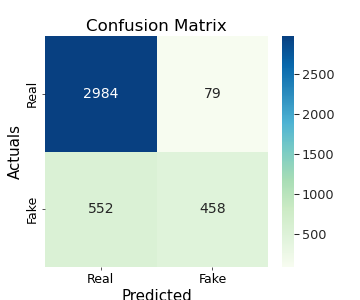

In [66]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_glove//fakenewsnet_cnn_cmtrx.png")

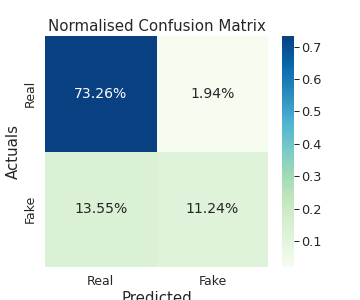

In [67]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_glove//fakenewsnet_cnn_ncmtrx.png")

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.844524621963501
Validation Accuracy : 0.8505218029022217
Precision : 0.8528864059590316
Recall : 0.4534653465346535
F1 Score : 0.5921137685843568


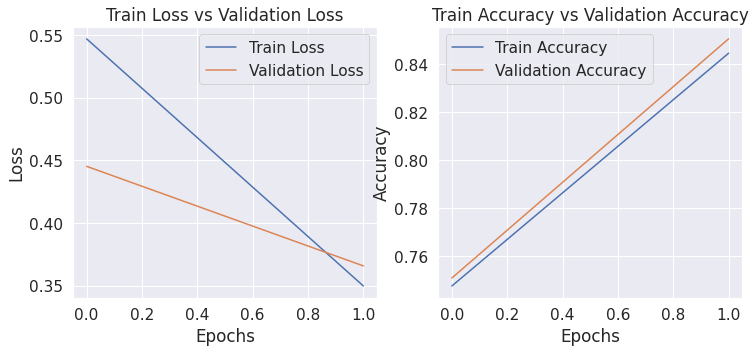

In [64]:
hist_df = pd.read_csv("outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_CNN_GLOVE_V1_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("LSTM Completed")

***

### LSTM

#### Checkpoint and EarlyStopping configuration setting for the model training

In [35]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_LSTM_GLOVE_PRETRAINED_V2.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model

In [36]:
from keras.initializers import Constant
lstm_model_g=Sequential()
lstm_model_g.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedding_gmatrix),trainable=True))
lstm_model_g.add(LSTM(128,return_sequences=True,dropout=0.2)) # loss stucks at about 
lstm_model_g.add(GlobalMaxPooling1D())
lstm_model_g.add(Dense(64,activation='relu'))
lstm_model_g.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
lstm_model_g.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [31]:
clear_session()

In [32]:
lstm_model_g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 300)        29623500  
                                                                 
 lstm (LSTM)                 (None, 10000, 128)        219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29,851,469
Trainable params: 29,851,469
Non-trainable params: 0
____________________________________________

#### Model Training

In [33]:
history_lstm_glove=lstm_model_g.fit(pad_train,y_train,epochs=3,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - ETA: 0s - loss: 0.4916 - accuracy: 0.7785 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2aafe3eea1e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

#### Load the saved model and Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [ ]:
from tensorflow.keras.models import load_model
lstm_model_g = load_model('outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_LSTM_GLOVE_PRETRAINED_V2.h5')


y_pred=lstm_model_g.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.4).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

In [ ]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

**Save the classification report to csv**

In [ ]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_LSTM_GLOVE_clasifctnrpt.csv")

**Plot confusion matrix with normalised plot**

In [ ]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakenewsnet_dl_glove//fakenewsnet_lstm_cmtrx.png"
path2="outputs//fakenewsnet_dl_glove//fakenewsnet_lstm_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

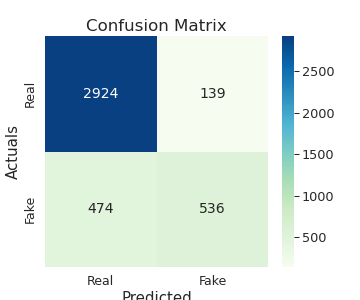

In [77]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_glove//fakenewsnet_lstm_cmtrx.png")

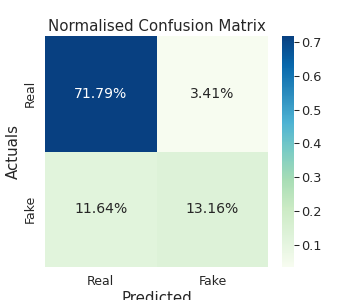

In [78]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_glove//fakenewsnet_lstm_ncmtrx.png")

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.8577238917350769
Validation Accuracy : 0.8505218029022217
Precision : 0.794074074074074
Recall : 0.5306930693069307
F1 Score : 0.6362017804154302


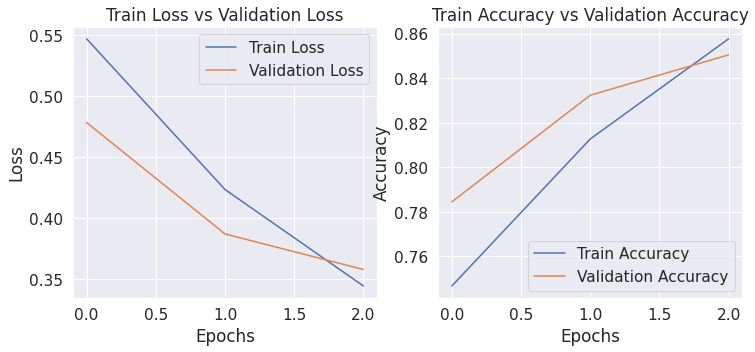

In [75]:
hist_df = pd.read_csv("outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_LSTM_GLOVE_V1_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("LSTM Completed")

***

### Bi-LSTM

#### Checkpoint and EarlyStopping configuration setting for the model training

In [29]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_BILSTM_GLOVE_PRETRAINED_V2.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model

In [30]:
from keras.initializers import Constant
bilstm_model_g=Sequential()
bilstm_model_g.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedding_gmatrix),trainable=True))
bilstm_model_g.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))) # loss stucks at about 
bilstm_model_g.add(GlobalMaxPooling1D())
bilstm_model_g.add(Dense(64,activation='relu'))
bilstm_model_g.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
bilstm_model_g.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [31]:
clear_session()

In [32]:
bilstm_model_g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 300)        29051400  
                                                                 
 bidirectional (Bidirectiona  (None, 10000, 256)       439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29,507,209
Trainable params: 29,507,209
No

#### Model Training

In [33]:
history_bilstm_glove=bilstm_model_g.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - ETA: 0s - loss: 0.4840 - accuracy: 0.7860 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b12b69e3a60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

#### Load the saved model and Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [ ]:
from tensorflow.keras.models import load_model
bilstm_model_g = load_model('outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_BILSTM_GLOVE_PRETRAINED_V2.h5')


y_pred=bilstm_model_g.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

In [ ]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

**Save the classification report to csv**

In [ ]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_BILSTM_GLOVE_clasifctnrpt.csv")

**Plot confusion matrix with normalised plot**

In [ ]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakenewsnet_dl_glove//fakenewsnet_bilstm_cmtrx.png"
path2="outputs//fakenewsnet_dl_glove//fakenewsnet_bilstm_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

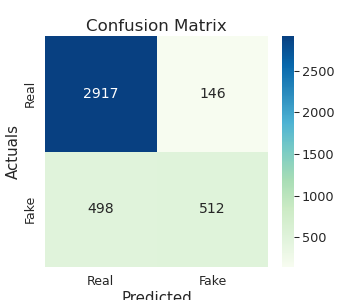

In [81]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_glove//fakenewsnet_bilstm_cmtrx.png")

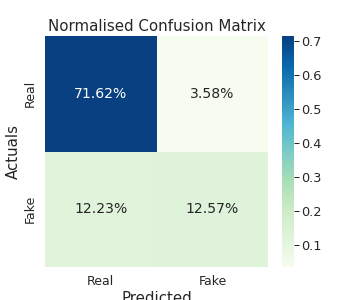

In [82]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_glove//fakenewsnet_bilstm_ncmtrx.png")

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.8281022310256958
Validation Accuracy : 0.8406997919082642
Precision : 0.7781155015197568
Recall : 0.5069306930693069
F1 Score : 0.6139088729016786


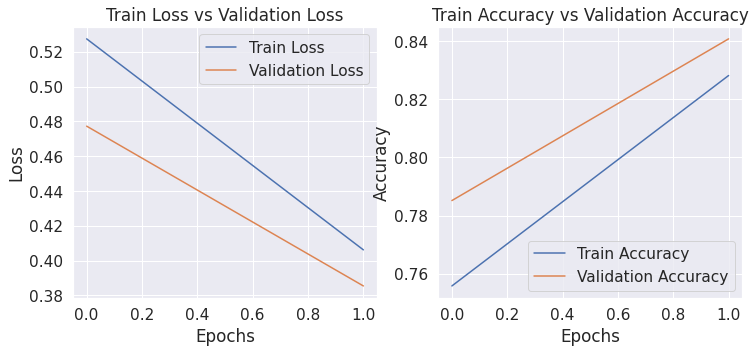

In [79]:
hist_df = pd.read_csv("outputs//fakenewsnet_dl_glove//model_FAKENEWSNET_BILSTM_GLOVE_V1_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("LSTM Completed")